In [201]:
# !conda install -c conda-forge librosa

# !conda install tqdm

In [2]:
import torch as ch
import torch.nn as nn
import torch.functional as F
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa

import tqdm

import torch.utils.data as Data
import datasets

In [3]:
import shutil

In [4]:
class C(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        super(C,self).__init__()
        self.causal = causal
        assert (k-1)%2 == 0 
        if causal:
            self.pad = (k-1)*d
        else:
#             print('filter',k,'dilation',d,'total pad',(k-1)*d,'half pad',(k-1)*d//2)
            self.pad = (k-1)*d // 2 
        self.conv = ch.nn.Conv1d(out_channels=o, in_channels=i,
                    kernel_size=k, dilation=d, stride=s, padding=self.pad)
        ch.nn.init.kaiming_normal_(self.conv.weight.data)
        self.dilation = d
    
    def forward(self,X):
        O = self.conv(X)
        return O[:,:,:-self.pad] if self.causal and self.pad else O

In [5]:
class Cs(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        super(C,self).__init__()
        self.causal = causal
        assert (k-1)%2 == 0 
        if causal:
            self.pad = (k-1)*d
        else:
            self.pad = (k-1)*d // 2 
#         self.conv = ch.nn.Conv1d(out_channels=o, in_channels=i,
#                     kernel_size=k, dilation=d, stride=s, padding=pad)
        self.depthwise = ch.nn.Conv1d(out_channels=i, in_channels=i,
                        kernel_size=k, dilation=d, stride=s,
                        padding=self.pad, groups=i)
        self.pointwise = ch.nn.Conv1d(out_channels=o, in_channels=i,kernel_size=1)
        ch.nn.init.kaiming_normal_(self.depthwise.weight.data)
        ch.nn.init.kaiming_normal_(self.pointwise.weight.data)
    
    def forward(self,X):
        O = self.pointwise(self.depthwise(X))
        return O[:,:,:-self.pad] if self.causal else O

In [6]:
class Css(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        super(C,self).__init__()
        self.causal = causal
        assert (k-1)%2 == 0 
        if causal:
            self.pad = (k-1)*d
        else:
            self.pad = (k-1)*d // 2 
#         self.conv = ch.nn.Conv1d(out_channels=o, in_channels=i,
#                     kernel_size=k, dilation=d, stride=s, padding=pad)
        self.depthwise = ch.nn.Conv1d(out_channels=i, in_channels=i,
                        kernel_size=k, dilation=d, stride=s,
                        padding=self.pad, groups=i)
        self.pointwise = ch.nn.Conv1d(out_channels=o, in_channels=i,
                                      kernel_size=1, groups=4)
        ch.nn.init.kaiming_normal_(self.depthwise.weight.data)
        ch.nn.init.kaiming_normal_(self.pointwise.weight.data)
    
    def forward(self,X):
        O = self.pointwise(self.depthwise(X))
        return O[:,:,:-self.pad] if self.causal else O

In [7]:
conv = C(8,4,3,1,0)
conv(ch.rand(3,4,10)).shape

torch.Size([3, 8, 10])

In [8]:
class D(ch.nn.Module):
    def __init__(self,o,i,k,d,causal=0,s=2):
        super(D,self).__init__()
        self.tconv = ch.nn.ConvTranspose1d(out_channels=o, in_channels=i, 
                       kernel_size=k, dilation=d, stride=s)
        ch.nn.init.kaiming_normal_(self.tconv.weight.data)
    
    def forward(self,X):
        return self.tconv(X)

In [9]:
class HC(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        assert o == i
        super(HC,self).__init__()
        self.o = o
        self.conv = C(2*o,i,k,d,causal,s)

    def forward(self,X):
        H = self.conv(X)
        H1,H2 = H[:,:self.o,:],H[:,self.o:,:]
        G = ch.sigmoid(H1)
        return G*H2 + (1-G)*X

In [10]:
class TextEnc(ch.nn.Module):
    def __init__(self,d,e,c2i):
        super(TextEnc,self).__init__()
        c = 0 # non causal
        self.embed = ch.nn.Embedding(len(c2i),e)
        ch.nn.init.kaiming_normal_(self.embed.weight.data)
        layers = [C(2*d,e,1,1,c),ch.nn.ReLU(),C(2*d,2*d,1,1,c)]
        for _ in range(2):
            layers += [HC(2*d,2*d,3,3**ldf,c) for ldf in range(4)]
        layers += [HC(2*d,2*d,3,1,c) for _ in range(2)]
        layers += [HC(2*d,2*d,1,1,c) for _ in range(2)]
        self.seq = ch.nn.Sequential(*layers)
    
    def forward(self,L):
        # permute b/c next layer expects dims to be [batch,embed,seq]
        # output of embed layer is [batch,seq,embed]
#         print(L.shape,self.embed(L).shape)
#         print(self.embed(L).permute(0,2,1).shape)
        return self.seq(self.embed(L).permute(0,2,1))

In [11]:
class AudioEnc(ch.nn.Module):
    def __init__(self,d,F):
        super(AudioEnc,self).__init__()
        c = 1 # causal
        layers = [C(d,F,1,1,c),ch.nn.ReLU(),C(d,d,1,1,c),ch.nn.ReLU(),C(d,d,1,1,c)]
        for _ in range(2):
            layers += [HC(d,d,3,3**ldf,c) for ldf in range(4)]
        layers += [HC(d,d,3,3,c) for _ in range(2)]
        self.seq = ch.nn.Sequential(*layers)
        
    def forward(self,S):
        return self.seq(S)

In [12]:
class Text2Mel(ch.nn.Module):
    def __init__(self,d,e,c2i,F):
        super(Text2Mel,self).__init__()
        self.d = d
        self.textEnc = TextEnc(d,e,c2i)
        self.audioEnc = AudioEnc(d,F)
    
    def forward(self,L,S):
        KV = self.textEnc(L)
        K,V = KV[:,:self.d,:],KV[:,self.d:,:]
        Q = self.audioEnc(S[:,:,:])
#         print('K',K.shape,'V',V.shape,'Q',Q.shape)
        A = ch.nn.Softmax(dim=1)(ch.matmul(ch.transpose(K,-1,-2),Q) / self.d**0.5)
        R = ch.matmul(V,A)
#         print('R',R.shape,'Q',Q.shape)
        return ch.cat([R,Q],dim=1),A

In [13]:
class AudioDec(ch.nn.Module):
    def __init__(self,d,F):
        super(AudioDec,self).__init__()
        s = 1 # causal
        layers = [C(d,2*d,1,1,s)]
        for _ in range(1): #?
            layers += [HC(d,d,3,3**ldf,s) for ldf in range(4)]
        layers += [HC(d,d,3,1,s) for _ in range(2)]
        for _ in range(3): 
            layers += [C(d,d,1,1,s),ch.nn.ReLU()]
        layers += [C(F,d,1,1,s),ch.nn.Sigmoid()]
        self.seq = ch.nn.Sequential(*layers)
    
    def forward(self,Rp):
        return self.seq(Rp)

In [14]:
class SSRN(ch.nn.Module):
    def __init__(self,c,F,Fp):
        super(SSRN,self).__init__()
        s = 0 # non causal
        layers = [C(c,F,1,1,s)]
        for _ in range(1): #?
            layers += [HC(c,c,3,1,s),HC(c,c,3,3,s)]
        for _ in range(2):
            layers += [D(c,c,2,1),HC(c,c,3,1,s),HC(c,c,3,3,s)]
        layers += [C(2*c,c,1,1,s)]
        layers += [HC(2*c,2*c,3,1,s) for _ in range(2)]
        layers += [C(Fp,2*c,1,1,s)]
        for _ in range(2):
            layers += [C(Fp,Fp,1,1,s),ch.nn.ReLU()]
        layers += [C(Fp,Fp,1,1,s),ch.nn.Sigmoid()]
        self.seq = ch.nn.Sequential(*layers)
    
    def forward(self,Y):
        return self.seq(Y)

In [15]:
# conv = C(3,2,3,1,0)
# tconv = D(3,2,2,1,2)
# hconv = HC(2,2,3,1,0)
# I.shape,conv(I).shape,tconv(I).shape,hconv(I).shape

In [136]:
class params:
    sep = 0
    alpha = 0.5
    d = int(256*alpha)
    e = int(128*alpha)
    c2i = datasets.LJSpeechDataset().c2i
    c = int(512*alpha)
    F = 80
    Fp = 513
    
    g=0.2
    
    lr = 2e-4
    init_lr=2e-4
    b1 = 0.5
    b2 = 0.9
    eps = 1e-6
    
    logevery = 200
    
    dropout_rate = 0.1
    masking = False
    
    gamma = 0.6
    eta = 1.3
    nFFT = 1024
    hopL = 256
    nMel = 80

In [17]:
# # textEnc = TextEnc(d=d,e=e,c2i=c2i)
# # audioEnc = AudioEnc(d=d,F=F)
# audioDec = AudioDec(d=params.d,F=params.F).to(dev)
# ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
# text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

# # alpha = 0.5, super-separable
# [sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,audioDec,ssrn)]

In [18]:
ch.cuda.current_device()
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
ch.multiprocessing.set_start_method("spawn",force=True)

In [19]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

In [20]:
class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A):
        _,N,T = A.shape
        W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*params.g**2)) 
                        for t in range(1,T+1)] 
                       for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()

In [21]:
L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def MelFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [22]:
def saveChkpt(state,model,root='.'):
#     chkptDir = os.path.join(root,'CHKPT'+''.join(p+str(v) for p,v in state['archparams']))
    chkptDir = root
    chkptPath = os.path.join(chkptDir,model+'Chkpt.pth.tar')
    bestPath = os.path.join(chkptDir,model+'Best.pth.tar')
    if not os.path.exists(chkptDir): os.makedirs(chkptDir)    
    ch.save(state,chkptPath)
    if state['lossHist'][-1] == state['bestLoss']:
        shutil.copyfile(chkptPath,bestPath)
    print("SAVED EPOCH {}, LOSS {}, BEST LOSS {}".format(state['epoch'],state['lossHist'][-1],state['bestLoss']))

In [23]:
def loadChkpt(networks,optimizer,model,root='.'):
    # return epoch num and best loss of checkpoint
    chkptDir = root
    chkptPath = os.path.join(chkptDir,model+'Chkpt.pth.tar')
    bestPath = os.path.join(chkptDir,model+'Best.pth.tar')
    if not os.path.exists(chkptPath): return 0,[],float('inf')
    state = ch.load(chkptPath)
    if model == 'text2Mel':
        text2Mel,audioDec = networks
        text2Mel.load_state_dict(state['text2MelState'])
        audioDec.load_state_dict(state['audioDecState'])
    elif model == 'ssrn':
        ssrn, = networks
        ssrn.load_state_dict(state['ssrnState'])
    optimizer.load_state_dict(state['optimizerState'])
    if len(state['lossHist']) > 10: plt.plot(state['lossHist'])
    print("LOADED EPOCH {}, LOSS {}, BEST LOSS {}".format(state['epoch'],state['lossHist'][-1],state['bestLoss']))
    return state['epoch'],state['lossHist'],state['bestLoss']

In [24]:
import datasets
from importlib import reload
reload(datasets)

text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=8)

audioDec = AudioDec(d=params.d,F=params.F).to(dev)
text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

text2MelOpt = ch.optim.Adam(set(text2Mel.parameters())|set(audioDec.parameters()),
                          lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

LOADED EPOCH 301, LOSS 0.024648341583783057, BEST LOSS 0.024648341583783057


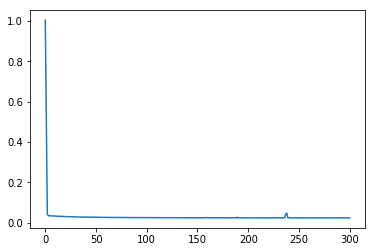

In [25]:
load = 1
if load:
    startEpoch,lossHist,bestLoss = loadChkpt((text2Mel,audioDec),text2MelOpt,'text2Mel')
else:
    # COLD START - RESET text2Mel
    audioDec = AudioDec(d=params.d,F=params.F).to(dev)
    text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)
    text2MelOpt = ch.optim.Adam(set(text2Mel.parameters())|set(audioDec.parameters()),
                      lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

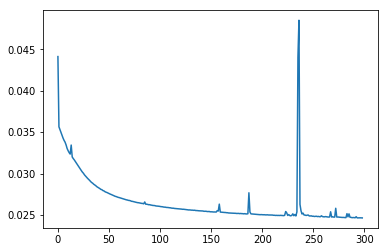

In [28]:
plt.plot(lossHist[2:])

EPOCH 5



epoch 5 total 0.27960572431325775 mel 0.04055023565888405 att 0.000128527419292368
EPOCH 6



epoch 6 total 0.24460561233589212 mel 0.03960851952433586 att 7.294100214494392e-05
EPOCH 7



epoch 7 total 0.21831629499555588 mel 0.03856975957751274 att 8.865385461831465e-05
EPOCH 8



epoch 8 total 0.19783783616846135 mel 0.03182113543152809 att 5.2621227951021865e-05
EPOCH 9



epoch 9 total 0.1814331087020147 mel 0.03541475906968117 att 6.242212111828849e-05
EPOCH 10



epoch 10 total 0.1679808970018025 mel 0.02422039397060871 att 6.640025821980089e-05
SAVED EPOCH 11, LOSS 0.033458779999680485, BEST LOSS 0.033458779999680485


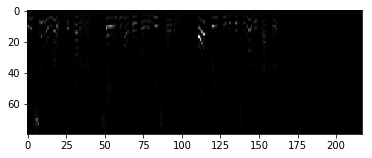

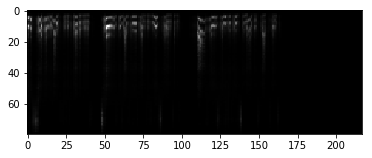

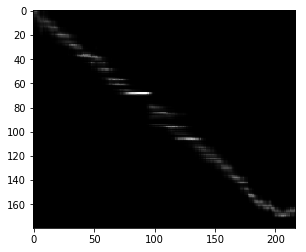

EPOCH 11



epoch 11 total 0.15673505174328925 mel 0.02159281261265278 att 6.755486538168043e-05
EPOCH 12



epoch 12 total 0.14719829594700748 mel 0.028171539306640625 att 7.588697917526588e-05
EPOCH 13



epoch 13 total 0.13900729929296898 mel 0.02666732296347618 att 8.721728227101266e-05
EPOCH 14



epoch 14 total 0.1318969087325234 mel 0.04596094414591789 att 0.00010624263086356223
EPOCH 15



epoch 15 total 0.12574336765434208 mel 0.03581486642360687 att 9.470181248616427e-05
EPOCH 16



epoch 16 total 0.12022931912394971 mel 0.03156275674700737 att 6.086023131501861e-05
EPOCH 17



epoch 17 total 0.11531733564948562 mel 0.026855550706386566 att 5.8946345234289765e-05
EPOCH 18



epoch 18 total 0.11091401600028948 mel 0.040835343301296234 att 8.925952715799212e-05
EPOCH 19



epoch 19 total 0.10694159212635726 mel 0.03122461959719658 att 6.402074359357357e-05
EPOCH 20



epoch 20 total 0.1033382138299798 mel 0.0331236869096756 att 7.053282024571672e-05
SAVED EPOCH 21, LOSS 0.031270647902430886, BEST LOSS 0.031270647902430886


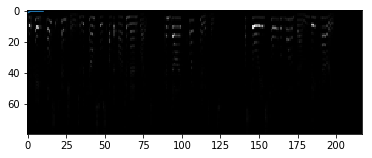

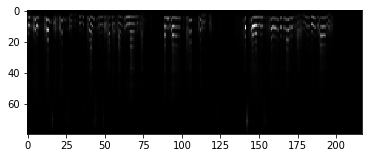

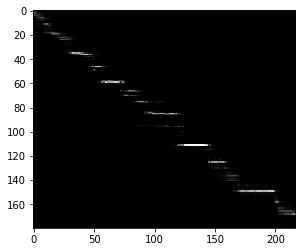

EPOCH 21



epoch 21 total 0.10005357386457994 mel 0.028159119188785553 att 0.00010712625953601673
EPOCH 22



epoch 22 total 0.09704707681187093 mel 0.03822245076298714 att 6.656315235886723e-05
EPOCH 23



epoch 23 total 0.09428236601663025 mel 0.022240545600652695 att 7.1102382207755e-05
EPOCH 24



epoch 24 total 0.09173137048922886 mel 0.01734011061489582 att 4.967294808011502e-05
EPOCH 25



epoch 26 total 0.08717783437369099 mel 0.029116909950971603 att 9.118105663219467e-05
EPOCH 27



epoch 27 total 0.08513695415814011 mel 0.04405513405799866 att 0.00010203961574006826
EPOCH 28



epoch 28 total 0.08323035347169186 mel 0.020428726449608803 att 7.950340659590438e-05
EPOCH 29



epoch 29 total 0.08144590852422266 mel 0.023426992818713188 att 7.427410309901461e-05
EPOCH 30



epoch 30 total 0.07977242226452484 mel 0.03349293768405914 att 8.895937935449183e-05
SAVED EPOCH 31, LOSS 0.029567834473590352, BEST LOSS 0.029567834473590352


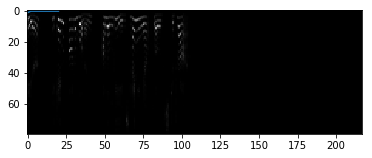

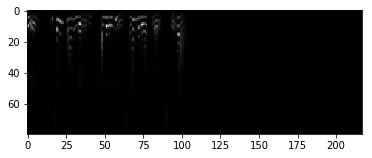

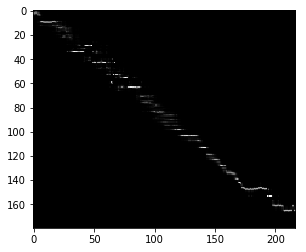

EPOCH 31


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 32 total 0.07671751498921325 mel 0.039629947394132614 att 6.824382580816746e-05
EPOCH 33



epoch 33 total 0.0753194181866838 mel 0.037484634667634964 att 7.819412712706253e-05
EPOCH 34



epoch 34 total 0.07399716080054534 mel 0.02288856729865074 att 7.470110722351819e-05
EPOCH 35



epoch 35 total 0.07274509066142576 mel 0.017633283510804176 att 5.700015390175395e-05
EPOCH 36



epoch 36 total 0.07155847979899352 mel 0.03889364376664162 att 8.588643686380237e-05
EPOCH 37



epoch 37 total 0.07043109852690167 mel 0.02451394498348236 att 5.887956285732798e-05
EPOCH 38



epoch 38 total 0.06935933687590992 mel 0.03592656925320625 att 8.030312892515212e-05
EPOCH 39


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 41 total 0.06643649412905304 mel 0.023668231442570686 att 6.219791248440742e-05
EPOCH 42



epoch 42 total 0.06554883889633918 mel 0.02766449935734272 att 7.892549911048263e-05
EPOCH 43



epoch 43 total 0.06469983438825783 mel 0.03360007703304291 att 6.087377551011741e-05
EPOCH 44



epoch 44 total 0.06388636849877244 mel 0.019333036616444588 att 7.174858910730109e-05
EPOCH 45



epoch 45 total 0.06310748029150721 mel 0.041047077625989914 att 7.003266364336014e-05
EPOCH 46



epoch 46 total 0.062359511383093515 mel 0.01991361565887928 att 7.055905734887347e-05
EPOCH 47



epoch 47 total 0.061641854838714094 mel 0.0411967933177948 att 8.387649722862989e-05
EPOCH 48


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 50 total 0.059649016748919016 mel 0.03858587518334389 att 9.028876229422167e-05
SAVED EPOCH 51, LOSS 0.02771508554969706, BEST LOSS 0.02771508554969706


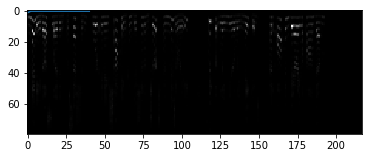

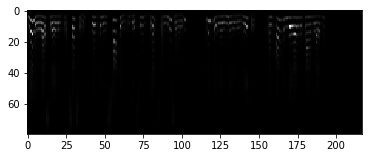

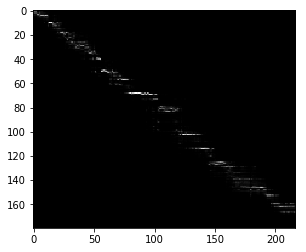

EPOCH 51



epoch 51 total 0.05903373013158396 mel 0.03781706839799881 att 9.839529229793698e-05
EPOCH 52



epoch 52 total 0.058440479469397025 mel 0.03354073315858841 att 8.188914944184944e-05
EPOCH 53



epoch 53 total 0.05786813377975554 mel 0.029232844710350037 att 6.596445018658414e-05
EPOCH 54



epoch 54 total 0.05731576302487695 mel 0.034840553998947144 att 0.00011297841410851106
EPOCH 55



epoch 55 total 0.056782074306448486 mel 0.028354061767458916 att 7.574936898890883e-05
EPOCH 56



epoch 56 total 0.05626620458984602 mel 0.02726365253329277 att 8.864900883054361e-05
EPOCH 57



epoch 57 total 0.05576708742988109 mel 0.025749804452061653 att 5.61404594918713e-05
EPOCH 58


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 60 total 0.05436308619596419 mel 0.019586432725191116 att 5.599757787422277e-05
SAVED EPOCH 61, LOSS 0.027173217488869802, BEST LOSS 0.027173217488869802


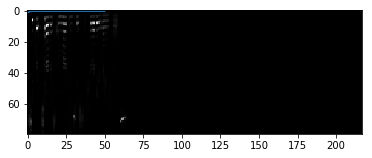

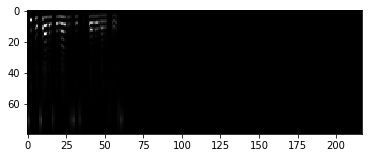

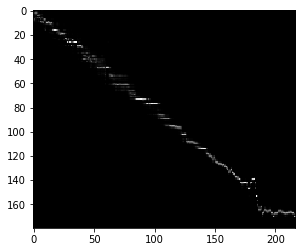

EPOCH 61



epoch 61 total 0.05392383209443434 mel 0.019228072836995125 att 5.679965761373751e-05
EPOCH 62



epoch 62 total 0.053498102120667114 mel 0.02800160087645054 att 7.9105440818239e-05
EPOCH 63



epoch 63 total 0.05308504702551006 mel 0.030961593613028526 att 6.388495967257768e-05
EPOCH 64


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 66 total 0.051915997702997936 mel 0.02041679248213768 att 4.801961040357128e-05
EPOCH 67



epoch 67 total 0.051548287126915414 mel 0.03335970267653465 att 6.260265945456922e-05
EPOCH 68



epoch 68 total 0.05119057484797752 mel 0.023016255348920822 att 5.377003253670409e-05
EPOCH 69



epoch 69 total 0.0508425947007549 mel 0.026633843779563904 att 6.893432873766869e-05
EPOCH 70



epoch 70 total 0.050504095063273136 mel 0.033049602061510086 att 7.033412111923099e-05
SAVED EPOCH 71, LOSS 0.02680912043954899, BEST LOSS 0.02680912043954899


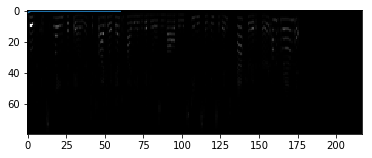

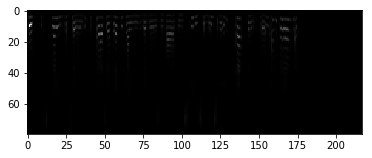

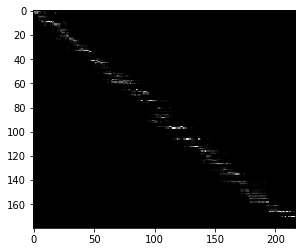

EPOCH 71



epoch 71 total 0.050174388916286006 mel 0.025753602385520935 att 8.424163388554007e-05
EPOCH 72


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 74 total 0.04923581168263731 mel 0.016012124717235565 att 4.77866233268287e-05
EPOCH 75



epoch 75 total 0.04893856709454166 mel 0.026586269959807396 att 6.624496745644137e-05
EPOCH 76



epoch 76 total 0.04864859361145081 mel 0.022215697914361954 att 5.4752839787397534e-05
EPOCH 77



epoch 77 total 0.04836555972005918 mel 0.015507188625633717 att 6.094288619351573e-05
EPOCH 78


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 83 total 0.04680270682676705 mel 0.019158219918608665 att 4.725886901724152e-05
EPOCH 84



epoch 84 total 0.04656269706148443 mel 0.02712581679224968 att 7.652609929209575e-05
EPOCH 85



epoch 85 total 0.046328158044196675 mel 0.03773288056254387 att 7.466914394171908e-05
EPOCH 86



epoch 86 total 0.046098533384590336 mel 0.022974064573645592 att 5.531014539883472e-05
EPOCH 87


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 94 total 0.044430374546158447 mel 0.02461293712258339 att 6.499368464574218e-05
EPOCH 95



epoch 95 total 0.0442399405845546 mel 0.015368430875241756 att 6.737551302649081e-05
EPOCH 96



epoch 96 total 0.04405343516081519 mel 0.03133648261427879 att 6.699610821669921e-05
EPOCH 97



epoch 97 total 0.04387052816048821 mel 0.030761223286390305 att 6.278780347201973e-05
EPOCH 98


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 104 total 0.04268229501918082 mel 0.03222886472940445 att 6.75744959153235e-05
EPOCH 105



epoch 105 total 0.042524658868086346 mel 0.02103482373058796 att 6.824699812568724e-05
EPOCH 106



epoch 106 total 0.04236973587293826 mel 0.015944980084896088 att 7.756492414046079e-05
EPOCH 107



epoch 107 total 0.042217705449113775 mel 0.03214384242892265 att 6.991320697125047e-05
EPOCH 108



epoch 108 total 0.04206816183465282 mel 0.015970565378665924 att 6.403518636943772e-05
EPOCH 109


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 113 total 0.041358171544671245 mel 0.015255835838615894 att 7.955067121656612e-05
EPOCH 114



epoch 114 total 0.041223068858943876 mel 0.017172150313854218 att 5.616612543235533e-05
EPOCH 115



epoch 115 total 0.041090296811286314 mel 0.024393834173679352 att 6.418857810785994e-05
EPOCH 116



epoch 116 total 0.04095955919796725 mel 0.018500231206417084 att 6.302737892838195e-05
EPOCH 117



epoch 117 total 0.04083095063764902 mel 0.02002922259271145 att 5.616178168565966e-05
EPOCH 118



epoch 118 total 0.04070434126407382 mel 0.01403879839926958 att 7.71610502852127e-05
EPOCH 119


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 120 total 0.040457306179415155 mel 0.026437295600771904 att 6.509079685201868e-05
SAVED EPOCH 121, LOSS 0.025750684916083493, BEST LOSS 0.025750684916083493


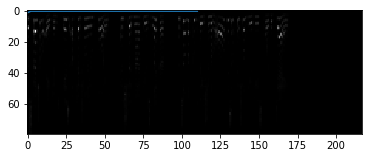

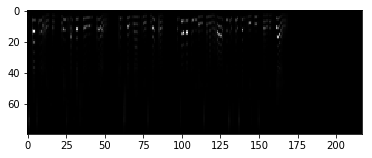

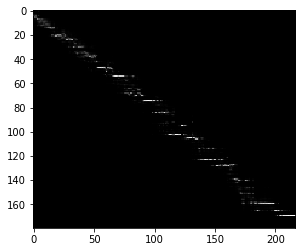

EPOCH 121



epoch 121 total 0.040336744754301206 mel 0.034795306622982025 att 0.00012401826097629964
EPOCH 122



epoch 122 total 0.04021796611637685 mel 0.025319978594779968 att 9.615725139155984e-05
EPOCH 123



epoch 123 total 0.04010098038785771 mel 0.025870386511087418 att 7.630426989635453e-05
EPOCH 124



epoch 124 total 0.03998569374290568 mel 0.021006302908062935 att 7.870296394685283e-05
EPOCH 125



epoch 125 total 0.039872268092270846 mel 0.033701878041028976 att 6.117516750236973e-05
EPOCH 126



epoch 126 total 0.03976053338504151 mel 0.03196191042661667 att 0.00010444250074215233
EPOCH 127


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 129 total 0.03943484019451028 mel 0.02059333026409149 att 7.531848677899688e-05
EPOCH 130



epoch 130 total 0.039329297520042154 mel 0.01510146725922823 att 4.503468153416179e-05
SAVED EPOCH 131, LOSS 0.025608749839185332, BEST LOSS 0.025608749839185332


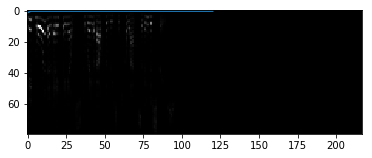

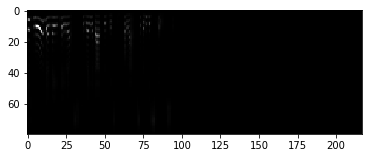

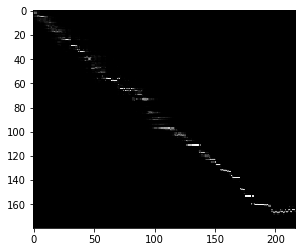

EPOCH 131



epoch 131 total 0.03922539245470705 mel 0.025456160306930542 att 6.107917579356581e-05
EPOCH 132



epoch 132 total 0.039122930828026786 mel 0.02510233223438263 att 4.93670413561631e-05
EPOCH 133


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 135 total 0.03882411593014406 mel 0.023398280143737793 att 4.982956306776032e-05
EPOCH 136



epoch 136 total 0.038727425748993245 mel 0.04175781458616257 att 7.001521589700133e-05
EPOCH 137



epoch 137 total 0.03863183914233039 mel 0.019012266770005226 att 5.9380134189268574e-05
EPOCH 138



epoch 138 total 0.03853764115652775 mel 0.029612505808472633 att 8.943744614953175e-05
EPOCH 139


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 141 total 0.038262391180572314 mel 0.025243235751986504 att 7.803684275131673e-05
EPOCH 142



epoch 142 total 0.03817310806507231 mel 0.02833615615963936 att 7.233193173306063e-05
EPOCH 143



epoch 143 total 0.038084927070746254 mel 0.022274089977145195 att 5.0807873776648194e-05
EPOCH 144



epoch 144 total 0.037998014100021855 mel 0.03270942345261574 att 6.479211879195645e-05
EPOCH 145



epoch 145 total 0.03791204655672388 mel 0.014595428481698036 att 8.90176888788119e-05
EPOCH 146


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 147 total 0.037743665781566495 mel 0.032562825828790665 att 5.7087458117166534e-05
EPOCH 148



epoch 148 total 0.03766097110981638 mel 0.01746220514178276 att 5.555733514484018e-05
EPOCH 149



epoch 149 total 0.03757931200424471 mel 0.01841178722679615 att 4.0394133975496516e-05
EPOCH 150



epoch 150 total 0.03749884529297509 mel 0.03934398293495178 att 8.451858593616635e-05
SAVED EPOCH 151, LOSS 0.025428838602531312, BEST LOSS 0.025428838602531312


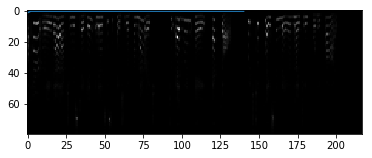

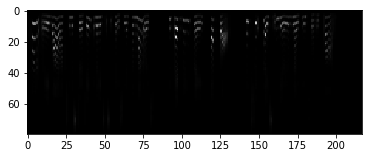

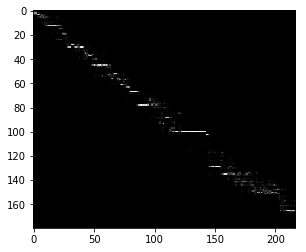

EPOCH 151



epoch 151 total 0.03741916746868218 mel 0.015281547792255878 att 4.9731934268493205e-05
EPOCH 152



epoch 152 total 0.03734052267004736 mel 0.022003212943673134 att 8.491767221130431e-05
EPOCH 153



epoch 153 total 0.037262877766360065 mel 0.025026222690939903 att 8.951104973675683e-05
EPOCH 154


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 156 total 0.03703556686102837 mel 0.03171173483133316 att 6.0810089053120464e-05
EPOCH 157



epoch 157 total 0.03696164050925061 mel 0.019493602216243744 att 7.464819645974785e-05
EPOCH 158



epoch 158 total 0.0368897150422175 mel 0.0185440331697464 att 5.270703695714474e-05
EPOCH 159



epoch 159 total 0.03681837440006474 mel 0.033000264316797256 att 8.099526894511655e-05
EPOCH 160


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 162 total 0.0366131404443796 mel 0.0275231022387743 att 6.50322181172669e-05
EPOCH 163



epoch 163 total 0.036544262791685204 mel 0.024335617199540138 att 7.461779023287818e-05
EPOCH 164



epoch 164 total 0.03647619744159026 mel 0.03145676851272583 att 7.077452028170228e-05
EPOCH 165



epoch 165 total 0.03640890682296967 mel 0.03169841319322586 att 6.539636524394155e-05
EPOCH 166


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 168 total 0.03621144344232468 mel 0.031118107959628105 att 6.722910620737821e-05
EPOCH 169



epoch 169 total 0.036146948292128084 mel 0.016457607969641685 att 6.964372005313635e-05
EPOCH 170



epoch 170 total 0.03608315671156516 mel 0.01765621080994606 att 5.119252818985842e-05
SAVED EPOCH 171, LOSS 0.025238588015868594, BEST LOSS 0.025238588015868594


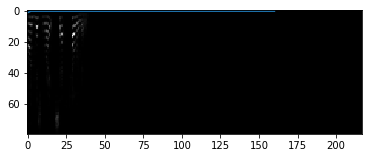

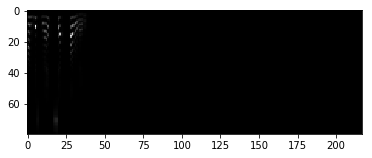

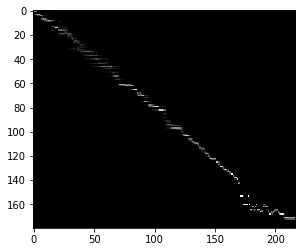

EPOCH 171



epoch 171 total 0.036020055093347145 mel 0.01645958423614502 att 5.990874342387542e-05
EPOCH 172



epoch 172 total 0.03595768474473353 mel 0.021274462342262268 att 5.416284329839982e-05
EPOCH 173


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 174 total 0.035834942943873925 mel 0.021724680438637733 att 5.11399884999264e-05
EPOCH 175



epoch 175 total 0.03577456904003367 mel 0.024300018325448036 att 6.071234020055272e-05
EPOCH 176



epoch 176 total 0.035714850092808975 mel 0.023941442370414734 att 5.453353878692724e-05
EPOCH 177



epoch 177 total 0.03565570025110158 mel 0.018720103427767754 att 0.00010280014976160601
EPOCH 178



epoch 178 total 0.03559723481381481 mel 0.026832621544599533 att 5.3413838031701744e-05
EPOCH 179


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 180 total 0.03548211947635442 mel 0.020409224554896355 att 5.740923006669618e-05
SAVED EPOCH 181, LOSS 0.025165762265782748, BEST LOSS 0.025165762265782748


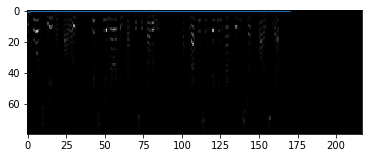

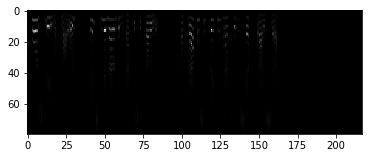

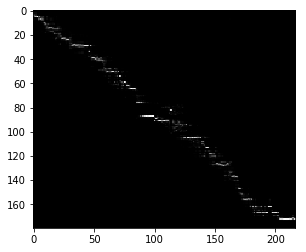

EPOCH 181



epoch 181 total 0.03542554579381865 mel 0.03809553384780884 att 7.511875446652994e-05
EPOCH 182



epoch 240 total 0.03307941543890688 mel 0.020351126790046692 att 8.752252324484289e-05
SAVED EPOCH 241, LOSS 0.025510317381860603, BEST LOSS 0.025510317381860603


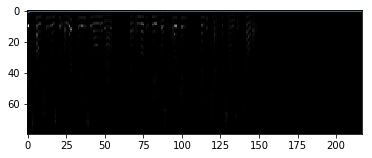

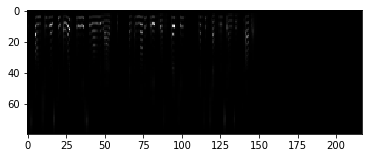

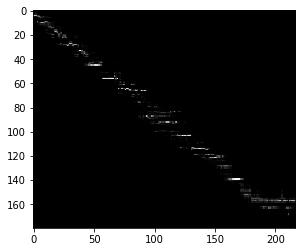

EPOCH 241



epoch 241 total 0.033046517066609604 mel 0.02922326698899269 att 5.943445648881607e-05
EPOCH 242



epoch 242 total 0.03301432112038237 mel 0.03503360599279404 att 6.766523438272998e-05
EPOCH 243



epoch 243 total 0.03298146018804979 mel 0.0336490236222744 att 7.746954361209646e-05
EPOCH 244



epoch 244 total 0.032948848581981154 mel 0.024078894406557083 att 5.371717270463705e-05
EPOCH 245



epoch 245 total 0.03291631116757547 mel 0.03893916308879852 att 8.0201803939417e-05
EPOCH 246



epoch 246 total 0.03288415763513273 mel 0.025200610980391502 att 8.622484165243804e-05
EPOCH 247



epoch 247 total 0.03285237872036904 mel 0.025904418900609016 att 6.768780440324917e-05
EPOCH 248



epoch 248 total 0.03282040161499696 mel 0.022644788026809692 att 0.00011653690307866782
EPOCH 249



epoch 249 total 0.032788636759853926 mel 0.018318206071853638 att 7.894371083239093e-05
EPOCH 250



epoch 250 total 0.03275721627494594 mel 0.030070148408412933 att 0.00010032110731117427
SAVED EPOCH 251, LOSS 0.024902095047951635, BEST LOSS 0.024902095047951635


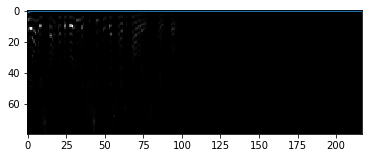

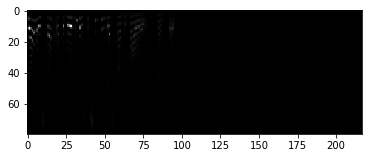

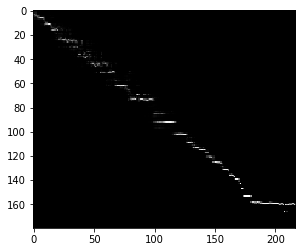

EPOCH 251



epoch 251 total 0.03272582813898461 mel 0.016738494858145714 att 5.544516534428112e-05
EPOCH 252



epoch 252 total 0.03269473380098887 mel 0.02146848663687706 att 6.058128201402724e-05
EPOCH 253



epoch 253 total 0.03266373618351422 mel 0.014959516003727913 att 3.515423304634169e-05
EPOCH 254



epoch 254 total 0.03263304808046136 mel 0.025132277980446815 att 7.151307363528758e-05
EPOCH 255



epoch 255 total 0.032602650492797924 mel 0.022716879844665527 att 7.085104880388826e-05
EPOCH 256



epoch 256 total 0.03257232931978686 mel 0.02230420708656311 att 8.583065209677443e-05
EPOCH 257



epoch 257 total 0.03254232072482462 mel 0.03266189247369766 att 7.867842214182019e-05
EPOCH 258



epoch 258 total 0.03251242296121962 mel 0.017424363642930984 att 5.066406083642505e-05
EPOCH 259



epoch 259 total 0.03248274581824595 mel 0.023175684735178947 att 6.23181986156851e-05
EPOCH 260



epoch 260 total 0.03245370997844823 mel 0.04258078709244728 att 7.610082684550434e-05
SAVED EPOCH 261, LOSS 0.024904391631039222, BEST LOSS 0.024904391631039222


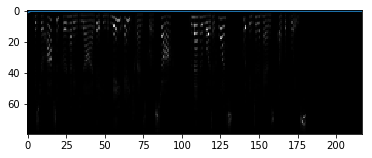

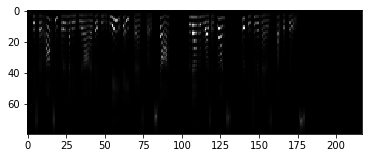

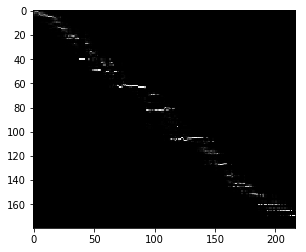

EPOCH 261



epoch 261 total 0.03242453525064379 mel 0.025826292112469673 att 6.810296326875687e-05
EPOCH 262



epoch 262 total 0.03239548581720013 mel 0.026255132630467415 att 4.738480129162781e-05
EPOCH 263



epoch 263 total 0.03236663538952458 mel 0.015334026888012886 att 0.00012841058196499944
EPOCH 264



epoch 264 total 0.03233811251347222 mel 0.03019261732697487 att 5.1903974963352084e-05
EPOCH 265



epoch 265 total 0.0323096989487427 mel 0.03498319163918495 att 8.70059520821087e-05
EPOCH 266



epoch 266 total 0.03228144237044093 mel 0.02505938895046711 att 4.953616007696837e-05
EPOCH 267



epoch 267 total 0.0322533496755748 mel 0.020982127636671066 att 6.393698276951909e-05
EPOCH 268



epoch 268 total 0.032225504050081906 mel 0.030600909143686295 att 7.388881203951314e-05
EPOCH 269



epoch 269 total 0.03220018511664988 mel 0.023731224238872528 att 0.0001388668461004272
EPOCH 270



epoch 270 total 0.03217271550243689 mel 0.015466224402189255 att 5.7569315686123446e-05
SAVED EPOCH 271, LOSS 0.024755919664931385, BEST LOSS 0.024755919664931385


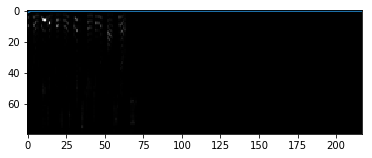

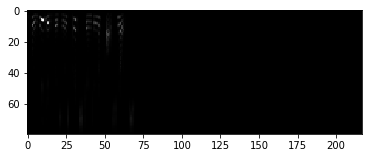

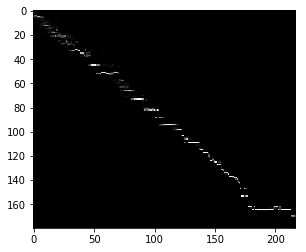

EPOCH 271



epoch 271 total 0.032145530515528105 mel 0.02797214314341545 att 6.478297291323543e-05
EPOCH 272



epoch 272 total 0.03211843451755271 mel 0.027323955669999123 att 7.490121788578108e-05
EPOCH 273



epoch 273 total 0.0320915408511286 mel 0.02844584360718727 att 8.430395246250555e-05
EPOCH 274



epoch 274 total 0.03206870706300224 mel 0.024459000676870346 att 6.653058517258614e-05
EPOCH 275



epoch 275 total 0.03204221298483457 mel 0.01700180023908615 att 5.7300549087813124e-05
EPOCH 276



epoch 276 total 0.03201590127993934 mel 0.027415189892053604 att 9.28788649616763e-05
EPOCH 277



epoch 277 total 0.03198977093799287 mel 0.03147527202963829 att 7.372102845693007e-05
EPOCH 278



epoch 278 total 0.031963740198382454 mel 0.0265331007540226 att 5.118494664202444e-05
EPOCH 279



epoch 279 total 0.031937887170428156 mel 0.02442796714603901 att 4.6720117097720504e-05
EPOCH 280



epoch 280 total 0.03191215674665955 mel 0.02049848809838295 att 5.884027268621139e-05
SAVED EPOCH 281, LOSS 0.024707638091449418, BEST LOSS 0.024707638091449418


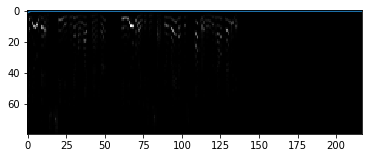

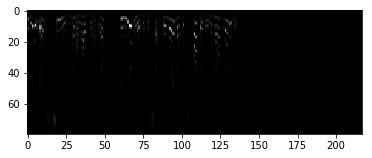

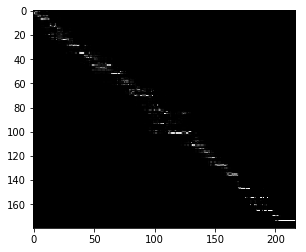

EPOCH 281



epoch 281 total 0.031886617131411624 mel 0.025398030877113342 att 5.6296463299077004e-05
EPOCH 282



epoch 282 total 0.03186124840815897 mel 0.028462003916502 att 7.597405056003481e-05
EPOCH 283



epoch 283 total 0.031835985639506556 mel 0.01542656123638153 att 7.227947935461998e-05
EPOCH 284



epoch 284 total 0.031810886360619704 mel 0.016660084947943687 att 4.0098169847624376e-05
EPOCH 285



epoch 285 total 0.03178763987742878 mel 0.02775772102177143 att 6.251594459172338e-05
EPOCH 286



epoch 286 total 0.031763218554878826 mel 0.027843547984957695 att 9.771794429980218e-05
EPOCH 287



epoch 287 total 0.03174021477057975 mel 0.029166877269744873 att 0.00011518262181198224
EPOCH 288



epoch 288 total 0.03171594953365668 mel 0.014445171691477299 att 0.00023209933715406805
EPOCH 289



epoch 289 total 0.031691803422753774 mel 0.019546067342162132 att 3.9337424823315814e-05
EPOCH 290



epoch 290 total 0.031667693467159745 mel 0.01582925394177437 att 4.331294621806592e-05
SAVED EPOCH 291, LOSS 0.024675806344889882, BEST LOSS 0.024675806344889882


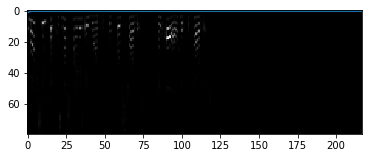

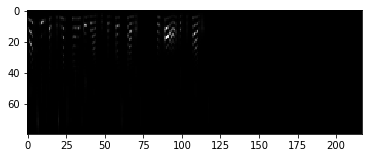

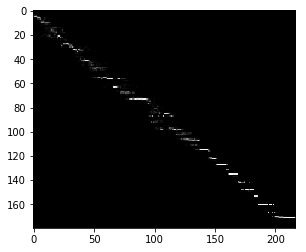

EPOCH 291



epoch 291 total 0.03164380530158452 mel 0.024381663650274277 att 6.240225047804415e-05
EPOCH 292



epoch 292 total 0.03162007280679407 mel 0.015673954039812088 att 6.10398783464916e-05
EPOCH 293



epoch 293 total 0.031596401338136605 mel 0.018639501184225082 att 0.00020369676349218935
EPOCH 294



epoch 294 total 0.03157334774905677 mel 0.026485400274395943 att 5.4234202252700925e-05
EPOCH 295



epoch 295 total 0.03154995819230706 mel 0.01907396875321865 att 4.04554812121205e-05
EPOCH 296



epoch 296 total 0.031526753100632667 mel 0.02296586148440838 att 9.550206596031785e-05
EPOCH 297



epoch 297 total 0.03150372224392475 mel 0.0348120778799057 att 0.00010967579873977229
EPOCH 298



epoch 298 total 0.031480838080522586 mel 0.029567215591669083 att 4.7403456846950576e-05
EPOCH 299



epoch 299 total 0.03145808022434686 mel 0.03225364536046982 att 5.566636173170991e-05
EPOCH 300



epoch 300 total 0.03143545650793302 mel 0.03024209663271904 att 0.00010003968054661527
SAVED EPOCH 301, LOSS 0.024648341583783057, BEST LOSS 0.024648341583783057


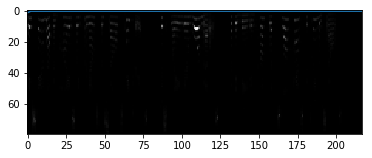

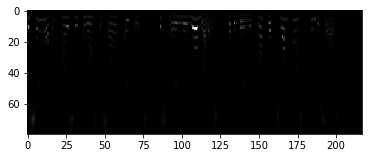

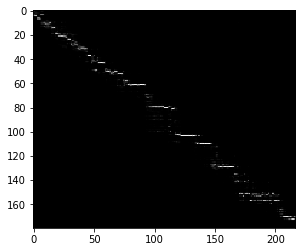

EPOCH 301



epoch 301 total 0.03141298727421587 mel 0.035614658147096634 att 7.239652040880173e-05
EPOCH 302



epoch 302 total 0.03139060794268044 mel 0.024383727461099625 att 6.745624705217779e-05
EPOCH 303



epoch 303 total 0.031369541177440036 mel 0.029755188152194023 att 6.781030242564157e-05
EPOCH 304



epoch 304 total 0.031349111453437634 mel 0.0212705060839653 att 0.00032017508056014776


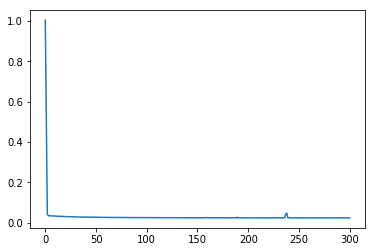

In [41]:
startEpoch = len(lossHist)
for epoch in range(startEpoch,startEpoch+300):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(batchL,batchS,_) in tqdm.tqdm_notebook(enumerate(text2MelLoader)):
        batchL = batchL.to(dev)
        batchS = batchS.to(dev)
        bL = ch.autograd.Variable(batchL)
        bS = ch.autograd.Variable(batchS)
        Rp,A = text2Mel(bL,bS)
        Shat = audioDec(Rp)
        melloss = MelFun(Shat[:,:,:-1],bS[:,:,1:])
        attloss = GAttFun(A)
        loss = melloss + attloss
        epochLoss.append(loss.data.item())
        text2MelOpt.zero_grad()
        loss.backward()
        text2MelOpt.step()
#         if step > 10: break
    lossHist.append(np.mean(epochLoss))
    print('epoch',epoch,'total',lossHist[-1],
      'mel',melloss.data.item(),'att',attloss.data.item())
    if epoch % 10 == 0:
        state = {
            'epoch': epoch + 1,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'text2MelState': text2Mel.state_dict(),
            'audioDecState': audioDec.state_dict(),
            'lossHist': lossHist,
            'bestLoss': min(lossHist[-1],bestLoss),
            'optimizerState': text2MelOpt.state_dict() 
        }
        saveChkpt(state,model='text2Mel')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

In [28]:
batchS.shape

torch.Size([16, 80, 217])

LOADED EPOCH 51, LOSS 0.1000639416833422, BEST LOSS 0.1000639416833422


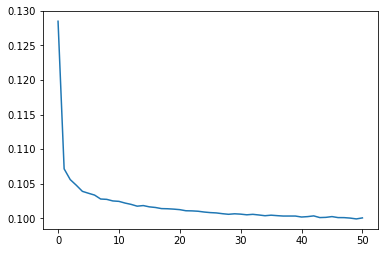

In [29]:
import datasets
from importlib import reload
reload(datasets)

ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=8)

ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)

ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load:
    startEpoch,lossHist,bestLoss = loadChkpt((ssrn,),ssrnOpt,'ssrn')
else:
    # COLD START - RESET SSRN
    ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
    ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

In [28]:
startEpoch = len(lossHist)
for epoch in range(startEpoch,startEpoch+1):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(_,batchS,batchY) in tqdm.tqdm_notebook(enumerate(ssrnLoader)):
        batchS = batchS.to(dev)
        batchY = batchY.to(dev)
        bS = ch.autograd.Variable(batchS)
        bY = ch.autograd.Variable(batchY)
        Yhat = ssrn(bS)
        loss = MelFun(Yhat,bY)
        epochLoss.append(loss.data.item())
        ssrnOpt.zero_grad()
        loss.backward()
        ssrnOpt.step()
    lossHist.append(np.mean(epochLoss))
    print('epoch',epoch,'total',np.mean(lossHist))
    if epoch % 10 == 0:
        state = {
            'epoch': epoch + 1,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'ssrnState': ssrn.state_dict(),
            'lossHist': lossHist,
            'bestLoss': min(lossHist[-1],bestLoss),
            'optimizerState': ssrnOpt.state_dict() 
        }
        saveChkpt(state,model='ssrn')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(bY[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

EPOCH 51



epoch 51 total 0.1018757302200702


In [34]:
L,S,Y = datasets.LJSpeechDataset(ttmel=1).__getitem__(1)
L.shape,S.shape,Y.shape

In [137]:
# !pip install lws
import lws

In [ ]:
dev = 'cpu'

In [117]:
text = "Bears. Beets. Battlestar Galactica".lower()
L = ch.Tensor([params.c2i[c] for c in text]).type(ch.LongTensor).to(dev).unsqueeze(0)
# initial audio enc
s0 = ch.zeros((80,1)).to(dev).unsqueeze(0)
S = s0

In [199]:
text2Mel = text2Mel.to(dev)
audioDec = audioDec.to(dev)
ssrn = ssrn.to(dev)

In [202]:
for t in tqdm.tqdm_notebook(range(100)):
    Rp,A = text2Mel(L,S)
    Shat = audioDec(Rp)
    S = ch.cat((s0,Shat),dim=2)

RuntimeError: CUDA error: out of memory

In [137]:
# !pip install lws
import lws

In [183]:
Y = ssrn(S)
# Y[Y<0] = 0 # doesn't happen
Y = Y ** (params.eta / params.gamma) * 50
Y = Y.cpu().detach().numpy().astype(np.float64)
Y = Y[0].T
Y[Y<0] = 0
print(type(Y))
print(Y.shape)

<class 'numpy.ndarray'>
(872, 513)


In [184]:
sum(sum(Y < 0))

0

In [185]:
lwsProc = lws.lws(params.nFFT,params.hopL,mode='speech',fftsize=params.nFFT)

In [187]:
Y = lwsProc.run_lws(Y)

In [189]:
Y = lwsProc.istft(Y)

In [190]:
print(Y.shape)

(224000,)


In [192]:
import IPython.display as ipd

In [196]:
ipd.Audio(Y,rate=22050)

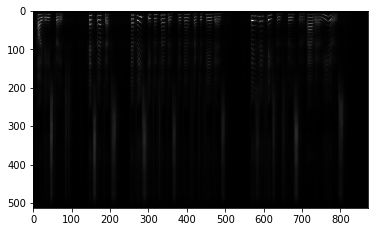

In [128]:
plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')

In [122]:
S.shape

torch.Size([1, 80, 218])

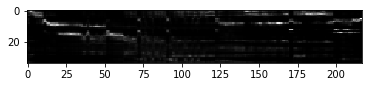

In [126]:
plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')

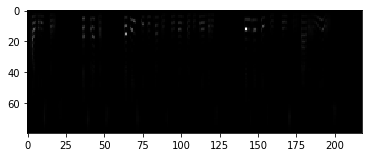

In [123]:
plt.imshow(S[0].cpu().detach().numpy(),cmap='gray')